Using device: cuda

Training the autoencoder...
0
Epoch:1, Loss:0.0021
1
Epoch:2, Loss:0.0017
2
Epoch:3, Loss:0.0012
3
Epoch:4, Loss:0.0011
4
Epoch:5, Loss:0.0010
5
Epoch:6, Loss:0.0009
6
Epoch:7, Loss:0.0008
7
Epoch:8, Loss:0.0009
8
Epoch:9, Loss:0.0009
9
Epoch:10, Loss:0.0008
10
Epoch:11, Loss:0.0009
11
Epoch:12, Loss:0.0008
12
Epoch:13, Loss:0.0008
13
Epoch:14, Loss:0.0008
14
Epoch:15, Loss:0.0007
15
Epoch:16, Loss:0.0007
16
Epoch:17, Loss:0.0007
17
Epoch:18, Loss:0.0007
18
Epoch:19, Loss:0.0006
19
Epoch:20, Loss:0.0007
20
Epoch:21, Loss:0.0007
21
Epoch:22, Loss:0.0007
22
Epoch:23, Loss:0.0007
23
Epoch:24, Loss:0.0006
24
Epoch:25, Loss:0.0006
25
Epoch:26, Loss:0.0006
26
Epoch:27, Loss:0.0007
27
Epoch:28, Loss:0.0006
28
Epoch:29, Loss:0.0006
29
Epoch:30, Loss:0.0006

Extracting features using the trained encoder...
Reducing feature dimensions with UMAP...


/home/operator0/anaconda3/envs/HydrophoneAnalysis/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering features with DBSCAN...
Found 1 clusters and 0 noise points.


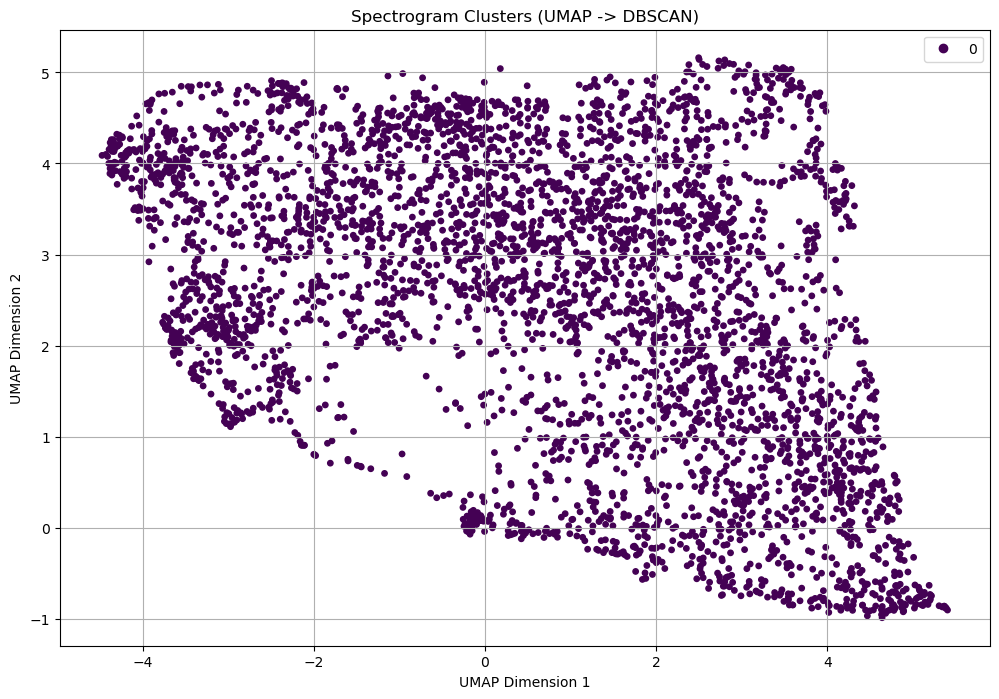


--- Samples from Cluster 0 ---


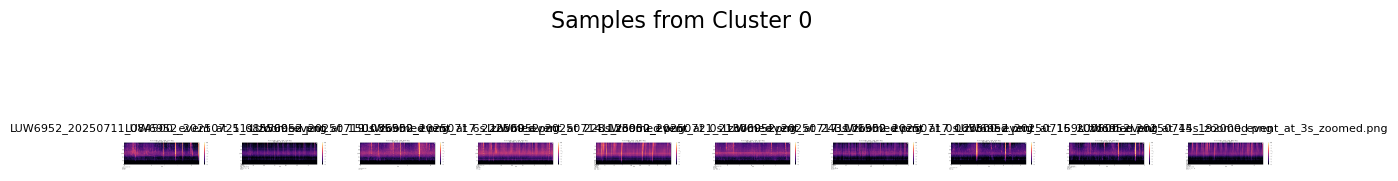

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.cluster import DBSCAN
import umap

# Suppress UMAP warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# --- 1. Configuration & Data Loading ---
# ==========================================

# UPDATE THIS PATH to the directory containing your spectrogram images
IMAGE_DIR =  "/run/user/1000/gvfs/smb-share:server=sl-nas.local,share=shared_all/_AZORES_NUUK/Natacha_Group/anomaly_files/Anomalies_Out/anomalies_output_refactored/high_quality_plots"
IMG_HEIGHT = 128
IMG_WIDTH = 128
LATENT_DIM = 32
BATCH_SIZE = 32
EPOCHS = 30

class SpectrogramDataset(Dataset):
    """Custom Dataset for loading spectrogram images."""
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filepath = os.path.join(self.image_dir, self.image_files[idx])
        # Open with PIL for compatibility with torchvision transforms
        image = Image.open(filepath).convert('L') # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, filepath

# Define transformations for the images
data_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(), # This also normalizes pixels to [0, 1]
])

# --- 2. Build the PyTorch Convolutional Autoencoder (CAE) ---
# =============================================================

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2) # Output: [N, 128, 16, 16]
        )
        self.encoder_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, latent_dim)
        )
        
        # Decoder
        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dim, 128 * 16 * 16),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128, 16, 16))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid() # Use Sigmoid for output in [0, 1] range
        )

    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.encoder_linear(x)
        return x

    def decode(self, x):
        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

    def forward(self, x):
        latent = self.encode(x)
        reconstruction = self.decode(latent)
        return reconstruction

# --- 3. Training and Feature Extraction ---
# ===========================================

if __name__ == '__main__':
    # Setup dataset and dataloader
    dataset = SpectrogramDataset(image_dir=IMAGE_DIR, transform=data_transform)
    if len(dataset) == 0:
        print(f"Error: No images found in '{IMAGE_DIR}'. Please check the path.")
    else:
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        # Setup device, model, loss, and optimizer
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        
        model = ConvAutoencoder(latent_dim=LATENT_DIM).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        # Training loop
        print("\nTraining the autoencoder...")
        for epoch in range(EPOCHS):
            print(epoch)
            for data, _ in dataloader:
                img = data.to(device)
                recon = model(img)
                loss = criterion(recon, img)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

        # Extract features
        print("\nExtracting features using the trained encoder...")
        model.eval() # Set model to evaluation mode
        features = []
        filepaths = []
        # Use a new dataloader without shuffling to keep file order
        full_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
        with torch.no_grad():
            for data, paths in full_dataloader:
                img = data.to(device)
                latent_vectors = model.encode(img)
                features.append(latent_vectors.cpu().numpy())
                filepaths.extend(paths)
        features = np.vstack(features)
        
        # --- 4. UMAP, Clustering, and Visualization ---
        # ==============================================

        # Reduce dimensionality with UMAP
        print("Reducing feature dimensions with UMAP...")
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        embedding = reducer.fit_transform(features)

        # Cluster with DBSCAN
        print("Clustering features with DBSCAN...")
        clusterer = DBSCAN(eps=0.5, min_samples=5)
        clusterer.fit(embedding)
        labels = clusterer.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"Found {n_clusters} clusters and {np.sum(labels == -1)} noise points.")

        # Plot the clustered results
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', s=15)
        plt.title('Spectrogram Clusters (UMAP -> DBSCAN)')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
        plt.grid(True)
        plt.show()

        # Show sample images from each cluster
        unique_labels = sorted(set(labels))
        for label in unique_labels:
            cluster_name = "Noise/Outliers" if label == -1 else f"Cluster {label}"
            print(f"\n--- Samples from {cluster_name} ---")
            
            indices = np.where(labels == label)[0]
            sample_indices = np.random.choice(indices, size=min(10, len(indices)), replace=False)
            
            fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 3))
            if len(sample_indices) == 1: axes = [axes]
                
            fig.suptitle(f'Samples from {cluster_name}', fontsize=16)
            for i, ax in enumerate(axes):
                img_path = filepaths[sample_indices[i]]
                img = cv2.imread(img_path)
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                ax.set_title(os.path.basename(img_path), fontsize=8)
                ax.axis('off')
            plt.show()

Reducing feature dimensions with UMAP...


/home/operator0/anaconda3/envs/HydrophoneAnalysis/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering features with DBSCAN...
Found 1 clusters and 1 noise points.


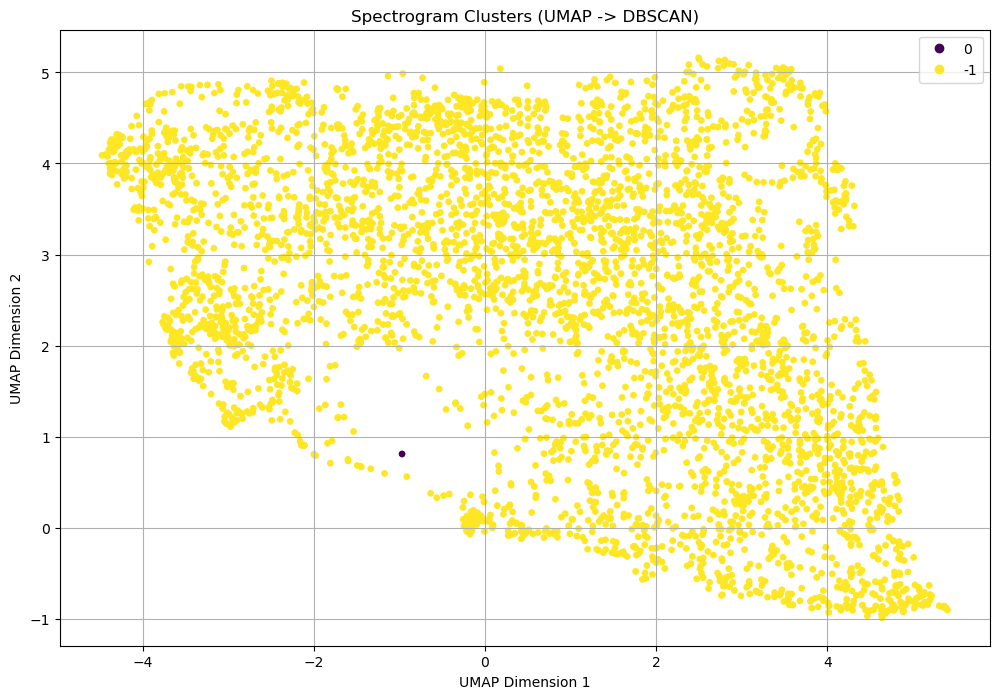


--- Samples from Noise/Outliers ---


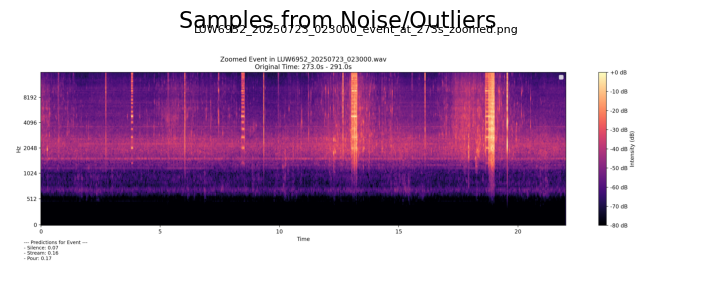


--- Samples from Cluster 0 ---


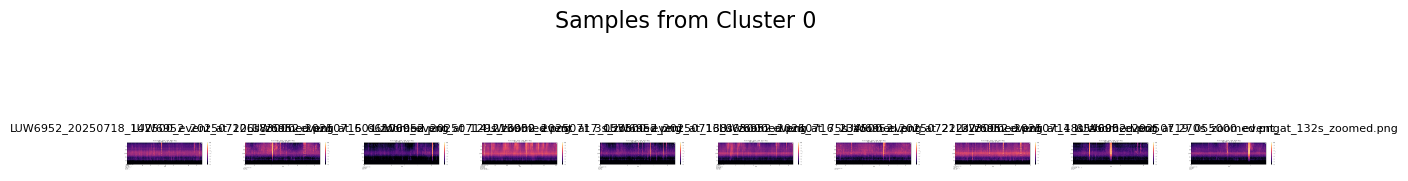

In [10]:

        # --- 4. UMAP, Clustering, and Visualization ---
        # ==============================================

        # Reduce dimensionality with UMAP
        print("Reducing feature dimensions with UMAP...")
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        embedding = reducer.fit_transform(features)

        # Cluster with DBSCAN
        print("Clustering features with DBSCAN...")
        clusterer = DBSCAN(eps=0.5, min_samples=15)
        clusterer.fit(embedding)
        labels = clusterer.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"Found {n_clusters} clusters and {np.sum(labels == -1)} noise points.")

        # Plot the clustered results
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', s=15)
        plt.title('Spectrogram Clusters (UMAP -> DBSCAN)')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
        plt.grid(True)
        plt.show()

        # Show sample images from each cluster
        unique_labels = sorted(set(labels))
        for label in unique_labels:
            cluster_name = "Noise/Outliers" if label == -1 else f"Cluster {label}"
            print(f"\n--- Samples from {cluster_name} ---")
            
            indices = np.where(labels == label)[0]
            sample_indices = np.random.choice(indices, size=min(10, len(indices)), replace=False)
            
            fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 3))
            if len(sample_indices) == 1: axes = [axes]
                
            fig.suptitle(f'Samples from {cluster_name}', fontsize=16)
            for i, ax in enumerate(axes):
                img_path = filepaths[sample_indices[i]]
                img = cv2.imread(img_path)
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                ax.set_title(os.path.basename(img_path), fontsize=8)
                ax.axis('off')
            plt.show()